In [35]:
import torch
import torch.nn as nn
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
import numpy as np
from get_data import NelsonData
import matplotlib.pyplot as plt

In [21]:
DEVICE = torch.device('cpu')

In [49]:
def func(params, y0):
    """This function solves the system to find the true mechanistic component
    for graphing."""
    def stress(t):
        if t < 30:
            return 0
        return torch.exp(-params['kdStress']*(t-30))

    def ode_rhs(y, t):
        y = torch.from_numpy(y).view(-1)
        dy = torch.zeros(4)

        # Apologies for the mess here, but typing out ODEs in Python is a bit of a
        #  chore
        wCRH = params['R0CRH'] + params['RCRH_CRH']*y[...,0] \
            + params['RSS_CRH']*stress(t) + params['RGR_CRH']*y[...,3]
        FCRH = (params['MaxCRH']*params['tsCRH'])/(1 + torch.exp(-params['sigma']*wCRH))
        dy[0] = FCRH - params['tsCRH']*y[...,0]
 
        wACTH = params['R0ACTH'] + params['RCRH_ACTH']*y[...,0] \
            + params['RGR_ACTH']*y[...,3]
        FACTH = (params['MaxACTH']*params['tsACTH'])/(1 + torch.exp(-params['sigma']*wACTH)) + params['BasalACTH']
        dy[1] = FACTH - params['tsACTH']*y[...,1]

        wCORT = params['R0CORT'] + params['RACTH_CORT']*y[...,1]
        FCORT = (params['MaxCORT']*params['tsCORT'])/(1 + torch.exp(-params['sigma']*wCORT)) + params['BasalCORT']
        dy[2] = FCORT - params['tsCORT']*y[...,2]

        wGR = params['R0GR'] + params['RCORT_GR']*y[...,2] + params['RGR_GR']*y[...,3]
        FGR = params['ksGR']/(1 + torch.exp(-params['sigma']*wGR))
        dy[3] = FGR - params['kdGR']*y[...,3]
        return dy

    t_eval = torch.linspace(0,140,40)
    gflow = odeint(ode_rhs, y0, t_eval)
    gflow = torch.from_numpy(gflow)
    gflow = torch.cat((t_eval.view(-1,1), gflow), dim=1)
    return gflow

In [273]:
def de_func(params, y0):
    if isinstance(params, dict):
        vals = []
        for key, val in params.items():
            vals.append(val.item())
        [R0CRH, RCRH_CRH, RGR_CRH, RSS_CRH, sigma, tsCRH, R0ACTH, RCRH_ACTH, RGR_ACTH, tsACTH, R0CORT, RACTH_CORT, tsCORT, R0GR, RCORT_GR, RGR_GR, kdStress, stressStr, MaxCRH, MaxACTH, MaxCORT, BasalACTH, BasalCORT, ksGR, kdGR] = vals
    else:
        [R0CRH, RCRH_CRH, RGR_CRH, RSS_CRH, sigma, tsCRH, R0ACTH, RCRH_ACTH, RGR_ACTH, tsACTH, R0CORT, RACTH_CORT, tsCORT, R0GR, RCORT_GR, RGR_GR, kdStress, stressStr, MaxCRH, MaxACTH, MaxCORT, BasalACTH, BasalCORT, ksGR, kdGR] = params
    """This function solves the system to find the true mechanistic component
    for graphing."""
    def stress(t):
        if t < 30:
            return 0
        return np.exp(-kdStress*(t-30))
    def ode_rhs(y, t):
        dy = np.zeros(4)

        # Apologies for the mess here, but typing out ODEs in Python is a bit of a
        #  chore
        wCRH = R0CRH + RCRH_CRH*y[0] \
            + RSS_CRH*stress(t) + RGR_CRH*y[3]
        FCRH = (MaxCRH*tsCRH)/(1 + np.exp(-sigma*wCRH))
        dy[0] = FCRH - tsCRH*y[0]
        
        wACTH = R0ACTH + RCRH_ACTH*y[0] \
            + RGR_ACTH*y[3]
        FACTH = (MaxACTH*tsACTH)/(1 + np.exp(-sigma*wACTH)) + BasalACTH
        dy[1] = FACTH - tsACTH*y[1]

        wCORT = R0CORT + RACTH_CORT*y[1]
        FCORT = (MaxCORT*tsCORT)/(1 + np.exp(-sigma*wCORT)) + BasalCORT
        dy[2] = FCORT - tsCORT*y[2]

        wGR = R0GR + RCORT_GR*y[2] + RGR_GR*y[3]
        FGR = ksGR/(1 + np.exp(sigma*wGR))
        dy[3] = FGR - kdGR*y[3]
        return dy

    #t_eval = torch.tensor((0, 15, 30, 40, 50, 65, 80, 95, 110, 125, 140))
    t_eval = torch.linspace(0, 140, 100)
    gflow = odeint(ode_rhs, y0, t_eval)
    gflow = np.concatenate((t_eval.view(-1,1), gflow), axis=1)
    gflow = torch.from_numpy(gflow)
    return gflow

In [214]:
def param_init_tsst(model: nn.Module):
    """Initialize the parameters for the mechanistic loss, and set them to
    require gradient"""
    R0CRH = torch.nn.Parameter(torch.tensor(-0.52239, device=DEVICE), requires_grad=False)
    RCRH_CRH = torch.nn.Parameter(torch.tensor(0.97555, device=DEVICE), requires_grad=False)
    RGR_CRH = torch.nn.Parameter(torch.tensor(-2.0241, device=DEVICE), requires_grad=False)
    RSS_CRH = torch.nn.Parameter(torch.tensor(9.8594, device=DEVICE), requires_grad=False)
    sigma = torch.nn.Parameter(torch.tensor(4.974, device=DEVICE), requires_grad=False)
    tsCRH = torch.nn.Parameter(torch.tensor(0.10008, device=DEVICE), requires_grad=False)
    R0ACTH = torch.nn.Parameter(torch.tensor(-0.29065, device=DEVICE), requires_grad=False)
    RCRH_ACTH = torch.nn.Parameter(torch.tensor(6.006, device=DEVICE), requires_grad=False)
    RGR_ACTH = torch.nn.Parameter(torch.tensor(-10.004, device=DEVICE), requires_grad=False)
    tsACTH = torch.nn.Parameter(torch.tensor(0.046655, device=DEVICE), requires_grad=False)
    R0CORT = torch.nn.Parameter(torch.tensor(-0.95265, device=DEVICE), requires_grad=False)
    RACTH_CORT = torch.nn.Parameter(torch.tensor(0.022487, device=DEVICE), requires_grad=False)
    tsCORT = torch.nn.Parameter(torch.tensor(0.048451, device=DEVICE), requires_grad=False)
    R0GR = torch.nn.Parameter(torch.tensor(-0.49428, device=DEVICE), requires_grad=False)
    RCORT_GR = torch.nn.Parameter(torch.tensor(0.02745, device=DEVICE), requires_grad=False)
    RGR_GR = torch.nn.Parameter(torch.tensor(0.10572, device=DEVICE), requires_grad=False)
    kdStress = torch.nn.Parameter(torch.tensor(0.19604, device=DEVICE), requires_grad=False)
    stressStr = torch.nn.Parameter(torch.tensor(1., device=DEVICE), requires_grad=False)
    MaxCRH = torch.nn.Parameter(torch.tensor(1.0011, device=DEVICE), requires_grad=False)
    MaxACTH = torch.nn.Parameter(torch.tensor(140.2386, device=DEVICE), requires_grad=False)
    MaxCORT = torch.nn.Parameter(torch.tensor(30.3072, device=DEVICE), requires_grad=False)
    BasalACTH = torch.nn.Parameter(torch.tensor(0.84733, device=DEVICE), requires_grad=False)
    BasalCORT = torch.nn.Parameter(torch.tensor(0.29757, device=DEVICE), requires_grad=False)
    ksGR = torch.nn.Parameter(torch.tensor(0.40732, device=DEVICE), requires_grad=False)
    kdGR = torch.nn.Parameter(torch.tensor(0.39307, device=DEVICE), requires_grad=False)

    params = {
        'R0CRH': R0CRH,
        'RCRH_CRH': RCRH_CRH,
        'RGR_CRH': RGR_CRH,
        'RSS_CRH': RSS_CRH,
        'sigma': sigma,
        'tsCRH': tsCRH,
        'R0ACTH': R0ACTH,
        'RCRH_ACTH': RCRH_ACTH,
        'RGR_ACTH': RGR_ACTH,
        'tsACTH': tsACTH,
        'R0CORT': R0CORT,
        'RACTH_CORT': RACTH_CORT,
        'tsCORT': tsCORT,
        'R0GR': R0GR,
        'RCORT_GR': RCORT_GR,
        'RGR_GR': RGR_GR,
        'kdStress': kdStress,
        'stressStr': stressStr,
        'MaxCRH': MaxCRH,
        'MaxACTH': MaxACTH,
        'MaxCORT': MaxCORT,
        'BasalACTH': BasalACTH,
        'BasalCORT': BasalCORT,
        'ksGR': ksGR,
        'kdGR': kdGR,
    }
    for key, val in params.items():
        model.register_parameter(key, val)
    return params

In [215]:
params = param_init_tsst(nn.Module())

In [249]:
bounds = []
for key, val in params.items():
    val = val.item()
    d = np.abs(val)*0.3
    bounds.append((val-d, val+d))

In [250]:
def loss(params, patient):

    gflow = de_func(params, y0)
    
    mse = gflow[:,[2,3]] - patient[:,[1,2]]
    mse = mse**2
    mse = torch.mean(mse)
    return mse
    return mse

In [272]:
dataset = NelsonData(['Control', 'Atypical', 'Melancholic', 'Neither'], 'None')
for idx,(patient,_) in enumerate(dataset):
    if idx < 15:
        patient_group = 'Control'
    elif idx < 29:
        patient_group = 'Atypical'
        idx -= 15
    elif idx < 44:
        patient_group = 'Melancholic'
        idx -= 29
    else:
        idx -= 44
        patient_group = 'Neither'
        
    print(f'{patient_group} #{idx}')
    y0 = torch.cat([torch.tensor([0]), patient[0,1:], torch.tensor([0])])
    res = differential_evolution(loss, bounds, args=(patient,), disp=True, maxiter=100)
    gflow = de_func(res.x, y0)
    
    fig, axes = plt.subplots(nrows=4, figsize=(10,8))
    for i in range(4):
        if i in [1,2]:
            axes[i].plot(patient[:,0], patient[:,i], 'o')
        axes[i].plot(gflow[:,0], gflow[:,i+1])
        
    plt.savefig(f'ODE Model vs Data/{patient_group}{idx}.png', dpi=300)
    plt.close(fig)
    
    np.savetxt(f'ODE Model vs Data/{patient_group}{idx}_opt_params.txt', res.x)

Control #0
differential_evolution step 1: f(x)= 59.9248
differential_evolution step 2: f(x)= 36.1029
differential_evolution step 3: f(x)= 32.4768
differential_evolution step 4: f(x)= 32.4768
differential_evolution step 5: f(x)= 32.4768
differential_evolution step 6: f(x)= 32.4768
differential_evolution step 7: f(x)= 25.6075
differential_evolution step 8: f(x)= 20.0674
differential_evolution step 9: f(x)= 20.0674
differential_evolution step 10: f(x)= 20.0674
differential_evolution step 11: f(x)= 18.5494
differential_evolution step 12: f(x)= 18.5494
differential_evolution step 13: f(x)= 16.5703
differential_evolution step 14: f(x)= 14.284
differential_evolution step 15: f(x)= 14.284
differential_evolution step 16: f(x)= 14.284
differential_evolution step 17: f(x)= 14.284
differential_evolution step 18: f(x)= 14.284
differential_evolution step 19: f(x)= 14.284
differential_evolution step 20: f(x)= 14.284
differential_evolution step 21: f(x)= 14.284
differential_evolution step 22: f(x)= 14

KeyboardInterrupt: 

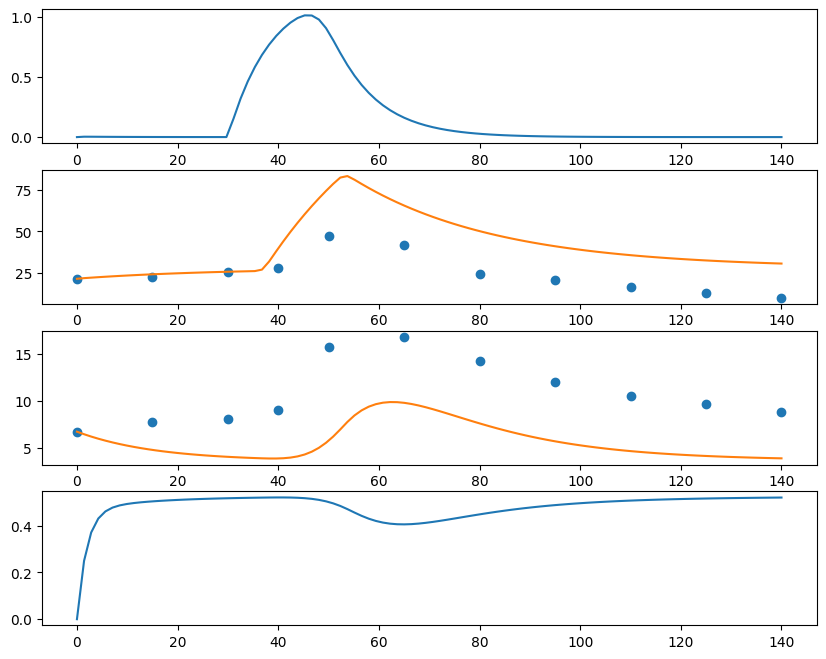

In [274]:
gflow = de_func(res.x, y0)
fig, axes = plt.subplots(nrows=4, figsize=(10,8))
for i in range(4):
    if i in [1,2]:
        axes[i].plot(patient[:,0], patient[:,i], 'o')
    axes[i].plot(gflow[:,0], gflow[:,i+1])

In [258]:
np.load('ODE Model vs Data/Control1_opt_params.txt')

ValueError: Cannot load file containing pickled data when allow_pickle=False